<a href="https://colab.research.google.com/github/arumajirou/ETNA/blob/main/backtest.ipynb" target="_parent"><img src="https://colab.research.google.com/assets/colab-badge.svg" alt="Open In Colab"/></a>

# バックテスト：過去データでの検証

<a href="https://mybinder.org/v2/gh/tinkoff-ai/etna/master?filepath=examples/backtest.ipynb">
    <img src="https://mybinder.org/badge_logo.svg"  align='left'>
</a>

このノートブックには、ETNAライブラリのバックテストモジュールを使用した時系列検証の簡単な例が含まれています。

- 目次

 - バックテストとは何か、どのように機能するか
 - バリデーションの実行方法
 - FoldMaskを使ったバックテスト
 - バリデーションビジュアライゼーション
 - メトリクスの可視化

In [9]:
!pip install --upgrade pip
!pip install etna

Looking in indexes: https://pypi.org/simple, https://us-python.pkg.dev/colab-wheels/public/simple/
Looking in indexes: https://pypi.org/simple, https://us-python.pkg.dev/colab-wheels/public/simple/


In [10]:
import pandas as pd
import matplotlib.pyplot as plt

from etna.datasets.tsdataset import TSDataset
from etna.metrics import MAE
from etna.metrics import MSE
from etna.metrics import SMAPE
from etna.pipeline import Pipeline
from etna.models import ProphetModel
from etna.analysis.plotters import plot_backtest

### **1.バックテストとは何か、どのように機能するか**

- バックテストは、過去のデータを基にした予測と検証のパイプラインで、モデルの正当なレトロテストを行うことができます。

- どのように機能するのですか？

- モデルを用いて予測を構築し、さらに予測指標を評価する場合、テストと呼ばれるある時間間隔での品質を測定する。

- バックテストは、モデルが過去にどのように機能するかをシミュレートすることができます。

 - 過去のものを選択します。

 - 選択された区間をトレーニングサンプルとしてモデルを構築する

 - テスト間隔での値を予測し、メトリックスを計算します。

画像は、n_folds = 3でバックテストパイプラインをプロットしたものです。

In [11]:
csv_path ="https://github.com/tinkoff-ai/etna/raw/master/examples/data/example_dataset.csv"
df = pd.read_csv(csv_path)
df["timestamp"] = pd.to_datetime(df["timestamp"])
df = df.loc[df.segment == "segment_a"]
df.head()

,timestamp,segment,target
0,2019-01-01,segment_a,170
1,2019-01-02,segment_a,243
2,2019-01-03,segment_a,267
3,2019-01-04,segment_a,287
4,2019-01-05,segment_a,279



- 本ライブラリは、空間データ構造TSDatasetで動作します。
- そこで、EDAを始める前に、古典的なDataFrameをTSDatasetに変換する必要があります。

In [12]:
df = TSDataset.to_dataset(df)
ts = TSDataset(df, freq="D")

### **シリーズで見てみよう**

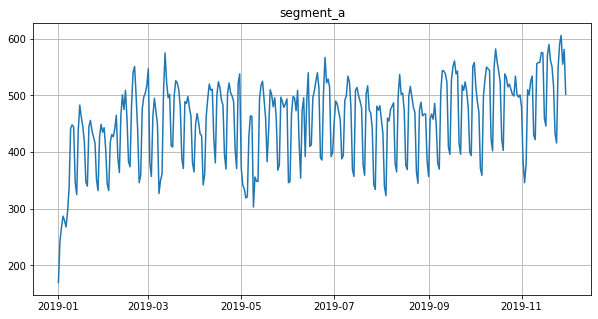

In [13]:
ts.plot(segments=["segment_a"])

### **2.バリデーションの実行方法**

まず、Prophetのモデルを作ってみましょう。

In [44]:
horizon = 31  # 予測の地平線を設定
model = ProphetModel()  # モデルの作成
transforms = []  #トランスフォームのリスト - いずれも使用しません。

### **パイプライン**

では、Pipelineのインスタンスを作ってみましょう。

In [46]:
pipeline = Pipeline(model=model,
                    transforms=transforms,
                    horizon=horizon)
pipeline

Pipeline(model = ProphetModel(growth = 'linear', changepoints = None, n_changepoints = 25, changepoint_range = 0.8, yearly_seasonality = 'auto', weekly_seasonality = 'auto', daily_seasonality = 'auto', holidays = None, seasonality_mode = 'additive', seasonality_prior_scale = 10.0, holidays_prior_scale = 10.0, changepoint_prior_scale = 0.05, mcmc_samples = 0, interval_width = 0.8, uncertainty_samples = 1000, stan_backend = None, additional_seasonality_params = (), ), transforms = [], horizon = 31, )

そのためのバックテスト・メソッドを実行します。

その結果、3つのデータフレームが返されます。

- 各フォールドと各セグメントに対するメトリックスを含むデータフレーム。
- データフレームに予測値を格納します。
- 折り目に関する情報を含むデータフレーム。

In [47]:
metrics_df, forecast_df, fold_info_df = pipeline.backtest(ts=ts, 
                                                          metrics=[MAE(),
                                                                   MSE(),
                                                                   SMAPE()
                                                                   ])

[Parallel(n_jobs=1)]: Using backend SequentialBackend with 1 concurrent workers.
INFO:prophet:Disabling yearly seasonality. Run prophet with yearly_seasonality=True to override this.
INFO:prophet:Disabling daily seasonality. Run prophet with daily_seasonality=True to override this.
DEBUG:cmdstanpy:input tempfile: /tmp/tmp4bpa2j9v/n71wnq7d.json
DEBUG:cmdstanpy:input tempfile: /tmp/tmp4bpa2j9v/2bf4irif.json
DEBUG:cmdstanpy:idx 0
DEBUG:cmdstanpy:running CmdStan, num_threads: None
DEBUG:cmdstanpy:CmdStan args: ['/usr/local/lib/python3.8/dist-packages/prophet/stan_model/prophet_model.bin', 'random', 'seed=76274', 'data', 'file=/tmp/tmp4bpa2j9v/n71wnq7d.json', 'init=/tmp/tmp4bpa2j9v/2bf4irif.json', 'output', 'file=/tmp/tmp4bpa2j9v/prophet_modelgb58w8fw/prophet_model-20221225122605.csv', 'method=optimize', 'algorithm=lbfgs', 'iter=10000']
12:26:05 - cmdstanpy - INFO - Chain [1] start processing
INFO:cmdstanpy:Chain [1] start processing
12:26:05 - cmdstanpy - INFO - Chain [1] done processing
I

In [48]:
metrics_df.head()

,segment,MAE,MSE,SMAPE,fold_number
0,segment_a,18.877607,597.469007,4.378189,0
0,segment_a,21.025154,673.137874,4.842466,1
0,segment_a,30.502645,1349.297219,6.391026,2
0,segment_a,35.950494,1995.343975,7.416735,3
0,segment_a,32.455953,1898.134390,6.556820,4


In [49]:
forecast_df.head()

segment      segment_a            
feature    fold_number      target
timestamp                         
2019-06-29           0  395.363413
2019-06-30           0  386.284295
2019-07-01           0  493.226942
2019-07-02           0  509.639340
2019-07-03           0  497.807373

In [50]:
fold_info_df.head()

,train_start_time,train_end_time,test_start_time,test_end_time,fold_number
0,2019-01-01,2019-06-28,2019-06-29,2019-07-29,0
0,2019-01-01,2019-07-29,2019-07-30,2019-08-29,1
0,2019-01-01,2019-08-29,2019-08-30,2019-09-29,2
0,2019-01-01,2019-09-29,2019-09-30,2019-10-30,3
0,2019-01-01,2019-10-30,2019-10-31,2019-11-30,4


さらに、フォールド数で平均化された指標を得ることができます。

In [20]:
metrics_df, forecast_df, fold_info_df = pipeline.backtest(
    ts=ts,
    metrics=[MAE(),
             MSE(),
             SMAPE()],
              aggregate_metrics=True
)

[Parallel(n_jobs=1)]: Using backend SequentialBackend with 1 concurrent workers.
INFO:prophet:Disabling yearly seasonality. Run prophet with yearly_seasonality=True to override this.
INFO:prophet:Disabling daily seasonality. Run prophet with daily_seasonality=True to override this.
DEBUG:cmdstanpy:input tempfile: /tmp/tmp4bpa2j9v/94anseyi.json
DEBUG:cmdstanpy:input tempfile: /tmp/tmp4bpa2j9v/ti1wjh6r.json
DEBUG:cmdstanpy:idx 0
DEBUG:cmdstanpy:running CmdStan, num_threads: None
DEBUG:cmdstanpy:CmdStan args: ['/usr/local/lib/python3.8/dist-packages/prophet/stan_model/prophet_model.bin', 'random', 'seed=32440', 'data', 'file=/tmp/tmp4bpa2j9v/94anseyi.json', 'init=/tmp/tmp4bpa2j9v/ti1wjh6r.json', 'output', 'file=/tmp/tmp4bpa2j9v/prophet_model2lf8fw60/prophet_model-20221225121739.csv', 'method=optimize', 'algorithm=lbfgs', 'iter=10000']
12:17:39 - cmdstanpy - INFO - Chain [1] start processing
INFO:cmdstanpy:Chain [1] start processing
12:17:39 - cmdstanpy - INFO - Chain [1] done processing
I

In [21]:
metrics_df.head()

,segment,MAE,MSE,SMAPE
0,segment_a,27.762371,1302.676493,5.917047


In [22]:
forecast_df.head()

segment      segment_a            
feature    fold_number      target
timestamp                         
2019-06-29           0  395.363413
2019-06-30           0  386.284295
2019-07-01           0  493.226942
2019-07-02           0  509.639340
2019-07-03           0  497.807373

In [23]:
fold_info_df.head()

,train_start_time,train_end_time,test_start_time,test_end_time,fold_number
0,2019-01-01,2019-06-28,2019-06-29,2019-07-29,0
0,2019-01-01,2019-07-29,2019-07-30,2019-08-29,1
0,2019-01-01,2019-08-29,2019-08-30,2019-09-29,2
0,2019-01-01,2019-09-29,2019-09-30,2019-10-30,3
0,2019-01-01,2019-10-30,2019-10-31,2019-11-30,4


### **3.フォールドマスクによるバックテスト**

- FoldMask を使って、バックテスト用のストラテジーを使用することができます

 - FoldMask を作成するには、
     - first_train_timestamp,
     - last_train_timestamp,
     - target_timestamps 
 - を指定する必要があります。
 - そして、pipeline.backtest にn_foldsパラメータとして、マスクのリストを渡す必要があります。

- Sktimeの
     -  SlidingWindowSplitter、
     - ExpandingWindowSplitter、
     - SingleWindowSplitter
- に似た3つのストラテジーを考えてみましょう。

### **エキスパンドウィンドウスプリッター**
このバックテスト戦略では、mode="expand "のバックテストを使用することができます。

In [24]:
metrics_df, _, _ = pipeline.backtest(ts=ts, metrics=[MAE(), MSE(), SMAPE()], n_folds=3, mode="expand")

[Parallel(n_jobs=1)]: Using backend SequentialBackend with 1 concurrent workers.
INFO:prophet:Disabling yearly seasonality. Run prophet with yearly_seasonality=True to override this.
INFO:prophet:Disabling daily seasonality. Run prophet with daily_seasonality=True to override this.
DEBUG:cmdstanpy:input tempfile: /tmp/tmp4bpa2j9v/k9jtbegj.json
DEBUG:cmdstanpy:input tempfile: /tmp/tmp4bpa2j9v/2uq0diph.json
DEBUG:cmdstanpy:idx 0
DEBUG:cmdstanpy:running CmdStan, num_threads: None
DEBUG:cmdstanpy:CmdStan args: ['/usr/local/lib/python3.8/dist-packages/prophet/stan_model/prophet_model.bin', 'random', 'seed=79832', 'data', 'file=/tmp/tmp4bpa2j9v/k9jtbegj.json', 'init=/tmp/tmp4bpa2j9v/2uq0diph.json', 'output', 'file=/tmp/tmp4bpa2j9v/prophet_model3gunyn_3/prophet_model-20221225121744.csv', 'method=optimize', 'algorithm=lbfgs', 'iter=10000']
12:17:44 - cmdstanpy - INFO - Chain [1] start processing
INFO:cmdstanpy:Chain [1] start processing
12:17:44 - cmdstanpy - INFO - Chain [1] done processing
I

In [25]:
metrics_df

,segment,MAE,MSE,SMAPE,fold_number
0,segment_a,30.502645,1349.297219,6.391026,0
0,segment_a,35.950494,1995.343975,7.416735,1
0,segment_a,32.455953,1898.134390,6.556820,2


### **SingleWindowSplitter**

- このバックテスト戦略では、n_folds=1のパラメータで我々のバックテストを使用することができますし、
- データセットから特定のウィンドウが必要な場合は、FoldMaskでマスクを作成することができます。

In [26]:
from etna.pipeline import FoldMask
import numpy as np

In [27]:
# 1 マスクなし

metrics_df, _, _ = pipeline.backtest(ts=ts, metrics=[MAE(), MSE(), SMAPE()], n_folds=1)
metrics_df

[Parallel(n_jobs=1)]: Using backend SequentialBackend with 1 concurrent workers.
INFO:prophet:Disabling yearly seasonality. Run prophet with yearly_seasonality=True to override this.
INFO:prophet:Disabling daily seasonality. Run prophet with daily_seasonality=True to override this.
DEBUG:cmdstanpy:input tempfile: /tmp/tmp4bpa2j9v/r4sy6jwe.json
DEBUG:cmdstanpy:input tempfile: /tmp/tmp4bpa2j9v/1a7t7bgg.json
DEBUG:cmdstanpy:idx 0
DEBUG:cmdstanpy:running CmdStan, num_threads: None
DEBUG:cmdstanpy:CmdStan args: ['/usr/local/lib/python3.8/dist-packages/prophet/stan_model/prophet_model.bin', 'random', 'seed=35221', 'data', 'file=/tmp/tmp4bpa2j9v/r4sy6jwe.json', 'init=/tmp/tmp4bpa2j9v/1a7t7bgg.json', 'output', 'file=/tmp/tmp4bpa2j9v/prophet_modelwfhat71f/prophet_model-20221225121748.csv', 'method=optimize', 'algorithm=lbfgs', 'iter=10000']
12:17:48 - cmdstanpy - INFO - Chain [1] start processing
INFO:cmdstanpy:Chain [1] start processing
12:17:48 - cmdstanpy - INFO - Chain [1] done processing
I

,segment,MAE,MSE,SMAPE,fold_number
0,segment_a,32.455953,1898.13439,6.55682,0


In [28]:
# 2 特定のマスクを使用した場合
window_size = 85
first_train_timestamp = ts.index.min() + np.timedelta64(100, "D")
last_train_timestamp = first_train_timestamp + np.timedelta64(window_size, "D")
target_timestamps = pd.date_range(start=last_train_timestamp + np.timedelta64(1, "D"), periods=horizon)
mask = FoldMask(
    first_train_timestamp=first_train_timestamp,
    last_train_timestamp=last_train_timestamp,
    target_timestamps=target_timestamps,
)

In [29]:
# 1 マスクなし

metrics_df, _, _ = pipeline.backtest(ts=ts, metrics=[MAE(), MSE(), SMAPE()], n_folds=[mask])
metrics_df

[Parallel(n_jobs=1)]: Using backend SequentialBackend with 1 concurrent workers.
INFO:prophet:Disabling yearly seasonality. Run prophet with yearly_seasonality=True to override this.
INFO:prophet:Disabling daily seasonality. Run prophet with daily_seasonality=True to override this.
DEBUG:cmdstanpy:input tempfile: /tmp/tmp4bpa2j9v/uqg4b6_u.json
DEBUG:cmdstanpy:input tempfile: /tmp/tmp4bpa2j9v/x00nufwe.json
DEBUG:cmdstanpy:idx 0
DEBUG:cmdstanpy:running CmdStan, num_threads: None
DEBUG:cmdstanpy:CmdStan args: ['/usr/local/lib/python3.8/dist-packages/prophet/stan_model/prophet_model.bin', 'random', 'seed=10546', 'data', 'file=/tmp/tmp4bpa2j9v/uqg4b6_u.json', 'init=/tmp/tmp4bpa2j9v/x00nufwe.json', 'output', 'file=/tmp/tmp4bpa2j9v/prophet_model1oc1t2_u/prophet_model-20221225121750.csv', 'method=optimize', 'algorithm=newton', 'iter=10000']
12:17:50 - cmdstanpy - INFO - Chain [1] start processing
INFO:cmdstanpy:Chain [1] start processing
12:17:50 - cmdstanpy - INFO - Chain [1] done processing


,segment,MAE,MSE,SMAPE,fold_number
0,segment_a,39.782294,2191.914481,9.056343,0


### **スライディングウィンドウスプリッター**

このバックテスト戦略を実行するには、FoldMask を使用してフォールドマスクのリストを作成する必要があります。

In [30]:
n_folds = 3

In [31]:
def sliding_window_masks(window_size, n_folds):
    masks = []
    for n in range(n_folds):
        first_train_timestamp = ts.index.min() + np.timedelta64(100, "D") + np.timedelta64(n, "D")
        last_train_timestamp = first_train_timestamp + np.timedelta64(window_size, "D")
        target_timestamps = pd.date_range(start=last_train_timestamp + np.timedelta64(1, "D"), periods=horizon)
        mask = FoldMask(
            first_train_timestamp=first_train_timestamp,
            last_train_timestamp=last_train_timestamp,
            target_timestamps=target_timestamps,
        )
        masks.append(mask)
    return masks

In [32]:
masks = sliding_window_masks(window_size=window_size, n_folds=n_folds)
metrics_df, _, _ = pipeline.backtest(ts=ts, metrics=[MAE(), MSE(), SMAPE()], n_folds=masks)

[Parallel(n_jobs=1)]: Using backend SequentialBackend with 1 concurrent workers.
INFO:prophet:Disabling yearly seasonality. Run prophet with yearly_seasonality=True to override this.
INFO:prophet:Disabling daily seasonality. Run prophet with daily_seasonality=True to override this.
DEBUG:cmdstanpy:input tempfile: /tmp/tmp4bpa2j9v/7y8qa0ps.json
DEBUG:cmdstanpy:input tempfile: /tmp/tmp4bpa2j9v/9o2p24ea.json
DEBUG:cmdstanpy:idx 0
DEBUG:cmdstanpy:running CmdStan, num_threads: None
DEBUG:cmdstanpy:CmdStan args: ['/usr/local/lib/python3.8/dist-packages/prophet/stan_model/prophet_model.bin', 'random', 'seed=60919', 'data', 'file=/tmp/tmp4bpa2j9v/7y8qa0ps.json', 'init=/tmp/tmp4bpa2j9v/9o2p24ea.json', 'output', 'file=/tmp/tmp4bpa2j9v/prophet_modelbka0_01c/prophet_model-20221225121752.csv', 'method=optimize', 'algorithm=newton', 'iter=10000']
12:17:52 - cmdstanpy - INFO - Chain [1] start processing
INFO:cmdstanpy:Chain [1] start processing
12:17:53 - cmdstanpy - INFO - Chain [1] done processing


In [33]:
metrics_df

,segment,MAE,MSE,SMAPE,fold_number
0,segment_a,39.782294,2191.914481,9.056343,0
0,segment_a,40.293273,2287.327211,9.108208,1
0,segment_a,39.861538,2192.546365,9.010128,2


4.バリデーションビジュアライゼーション

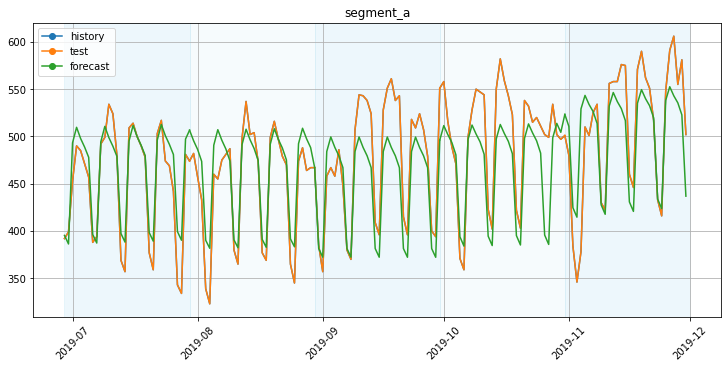

In [34]:
plot_backtest(forecast_df, ts)

To visualize the train part, you can specify the `history_len` parameter. 

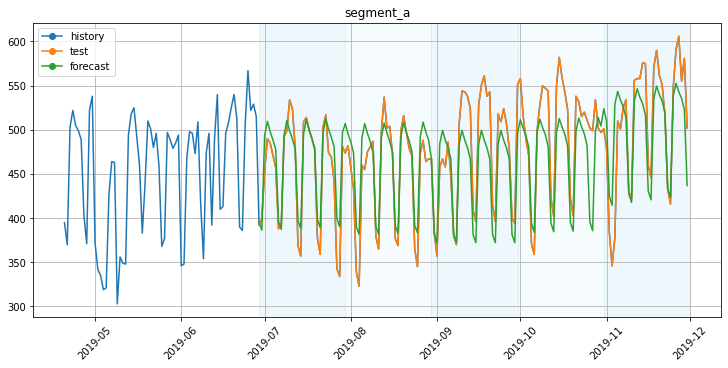

In [35]:
plot_backtest(forecast_df, ts, history_len=70)

### **5.メトリクスの可視化**

このセクションでは、バックテスト結果を様々な視点から分析します。

In [36]:
from etna.analysis import (
    metric_per_segment_distribution_plot,
    plot_residuals,
    plot_metric_per_segment,
    prediction_actual_scatter_plot,
)

In [38]:

df = pd.read_csv(csv_path)
df["timestamp"] = pd.to_datetime(df["timestamp"])
df = TSDataset.to_dataset(df)
ts_all = TSDataset(df, freq="D")

In [39]:
metrics_df, forecast_df, fold_info_df = pipeline.backtest(ts=ts_all, metrics=[MAE(), MSE(), SMAPE()])

[Parallel(n_jobs=1)]: Using backend SequentialBackend with 1 concurrent workers.
INFO:prophet:Disabling yearly seasonality. Run prophet with yearly_seasonality=True to override this.
INFO:prophet:Disabling daily seasonality. Run prophet with daily_seasonality=True to override this.
DEBUG:cmdstanpy:input tempfile: /tmp/tmp4bpa2j9v/s5e_1sh2.json
DEBUG:cmdstanpy:input tempfile: /tmp/tmp4bpa2j9v/2kpt2tob.json
DEBUG:cmdstanpy:idx 0
DEBUG:cmdstanpy:running CmdStan, num_threads: None
DEBUG:cmdstanpy:CmdStan args: ['/usr/local/lib/python3.8/dist-packages/prophet/stan_model/prophet_model.bin', 'random', 'seed=43271', 'data', 'file=/tmp/tmp4bpa2j9v/s5e_1sh2.json', 'init=/tmp/tmp4bpa2j9v/2kpt2tob.json', 'output', 'file=/tmp/tmp4bpa2j9v/prophet_model1qs_j7vh/prophet_model-20221225121852.csv', 'method=optimize', 'algorithm=lbfgs', 'iter=10000']
12:18:52 - cmdstanpy - INFO - Chain [1] start processing
INFO:cmdstanpy:Chain [1] start processing
12:18:52 - cmdstanpy - INFO - Chain [1] done processing
I

- SMAPE メトリクスの倍率による分布を見てみましょう。
- type_plotにはbox,violin,hist のいずれかを指定します。

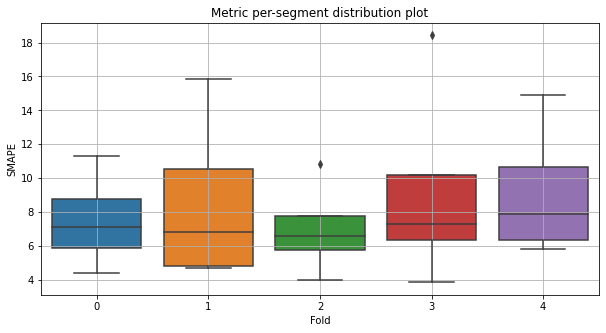

In [40]:
metric_per_segment_distribution_plot(metrics_df=metrics_df, metric_name="SMAPE", plot_type="box")

SMAPEの指標をセグメント別に見てみましょう。

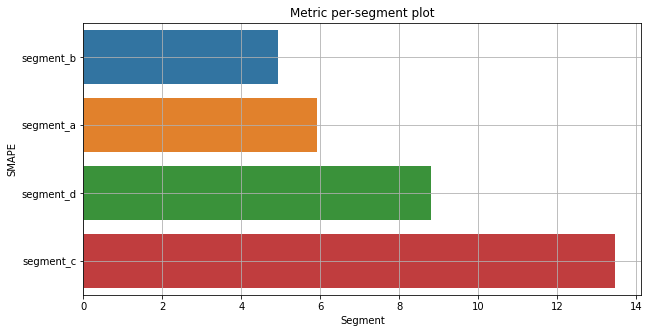

In [41]:
plot_metric_per_segment(metrics_df=metrics_df, metric_name="SMAPE", ascending=True)

- ここで、バックテストによるモデルの予測値の残差を見てみましょう。
残差の分析は、モデルが見つけられなかったデータ中の依存関係を確立するのに役立ちます。
- このようにして、機能を追加したり、モデルを改善したり、残差に依存性がないことを確認することができます。
- また、残差はタイムスタンプだけでなく、任意の特徴によって可視化することができます。

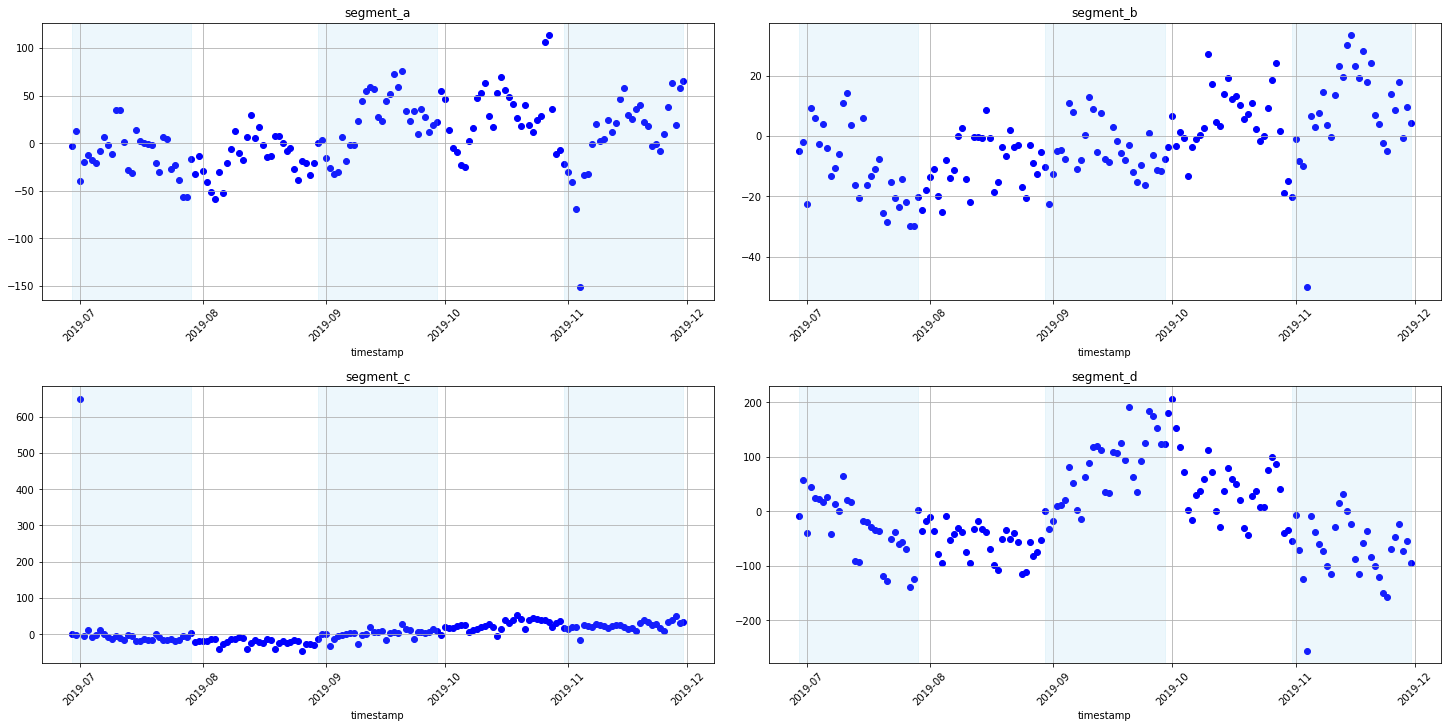

In [42]:
plot_residuals(forecast_df=forecast_df, ts=ts_all)

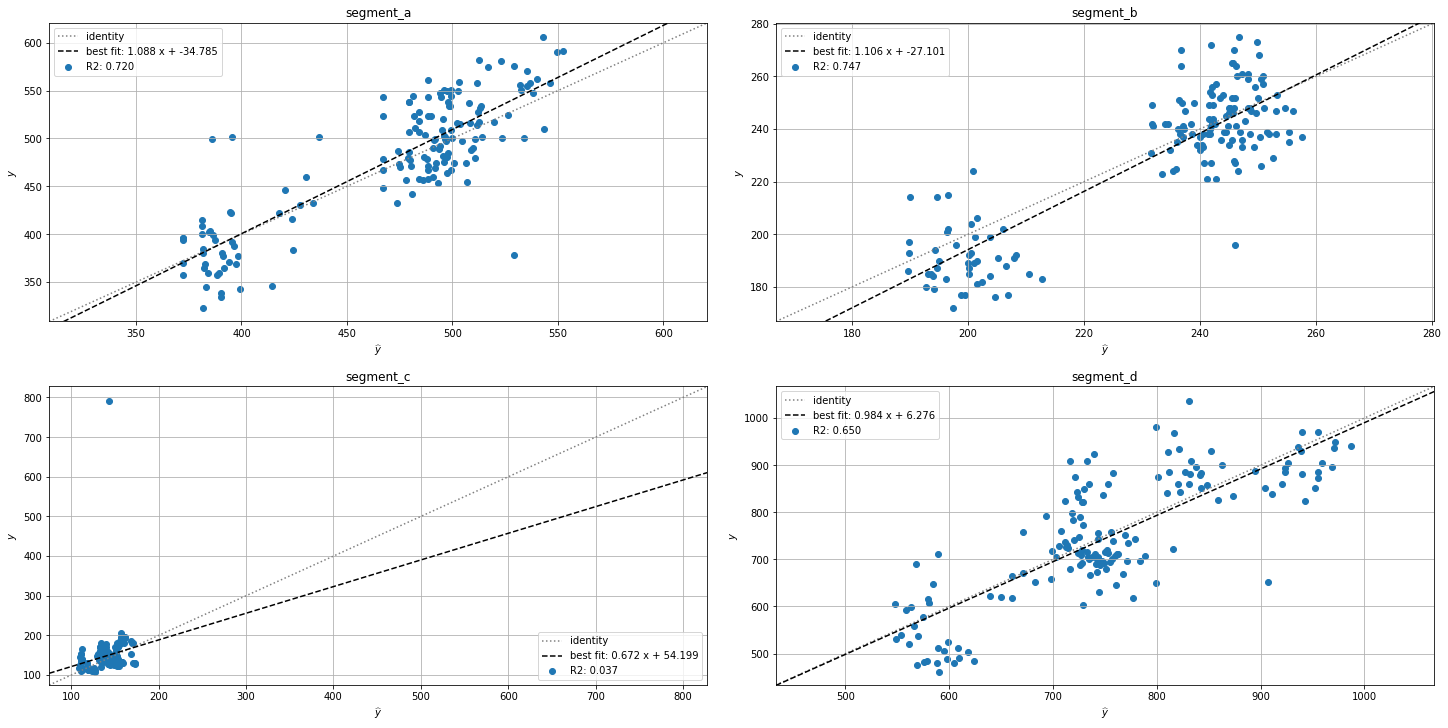

In [43]:
prediction_actual_scatter_plot(forecast_df=forecast_df, ts=ts_all)

このノートブックについては以上です。その他の機能はドキュメントをご覧ください。